In [ ]:
import robosandbox as rsb
import numpy as np

# How to add new robot indice in RoboSandbox (rsb)?


## Define the indice
For example, we want to add order independent manipulability: Kim and Khosla [70] solved the problem of dimensional dependency of the manipulability index by taking the geometric mean of the manipulability index ($\mu$). The dimension independent manipulability ($\mu_{O}$) for n-link manipulator is given as: 
$$
\mu_O=\sqrt[n]{\mu}=\sqrt[n]{\operatorname{det}\left(J \cdot J^T\right)}
$$


In [2]:
def order_independent_manipulability(
    workspace, joint_points, method="order_independent_manipulability", axes="all"
):
    """
    \sqrt[n]{(\operatorname{det}(\mathbf{H}(\mathbf{q}))}
    Calculate the order-independent manipulability index for a robot.

    :param workspace: The workspace instance providing access to the robot.
    :param joint_points: List of joint configurations to evaluate.
    :param method: The method name (for compatibility with the indice registry).
    :param axes: Which axes to consider ('all', 'trans', 'rot').
    :return: The order-independent manipulability indices for each configuration.
    """
    results = []

    for point in joint_points:
        J = workspace.robot.jacob0(point)
        H = J @ J.T

        # Get the determinant of the manipulability matrix
        det_H = np.linalg.det(H)

        # Calculate the nth root of the determinant (n is the matrix dimension)
        n = workspace.robot.dofs
        if det_H > 0:
            order_independent_manip = det_H ** (1 / n)
        else:
            order_independent_manip = 0

        results.append(order_independent_manip)

    return np.array(results)

## Calculate the indice

Steps to calculate the indice:
1. define the robot, such as `robot = rsb.models.DH.Panda()`
2. define the workspace `ws = WorkSpace(robot)`
3. register the new index `ws.add_indice(...)`
4. calculate the global indice `G = ws.global_indice(...)`

In [5]:
robot = rsb.models.DH.Panda()
ws = rsb.performance.workspace.WorkSpace(robot)

# Register the new manipulability index
ws.add_indice(
    method="order_independent_manipulability",
    function=order_independent_manipulability,
    description="Order-independent manipulability index (nth root of determinant)",
)

# Calculate the global indices
print("\nCalculating global indices (this may take a moment)...")
global_oim = ws.global_indice(method="order_independent_manipulability")
print(f"Global order-independent manipulability: {global_oim:.4f}")


Calculating global indices (this may take a moment)...
Global order-independent manipulability: 0.3603


## Visualize the workspace 

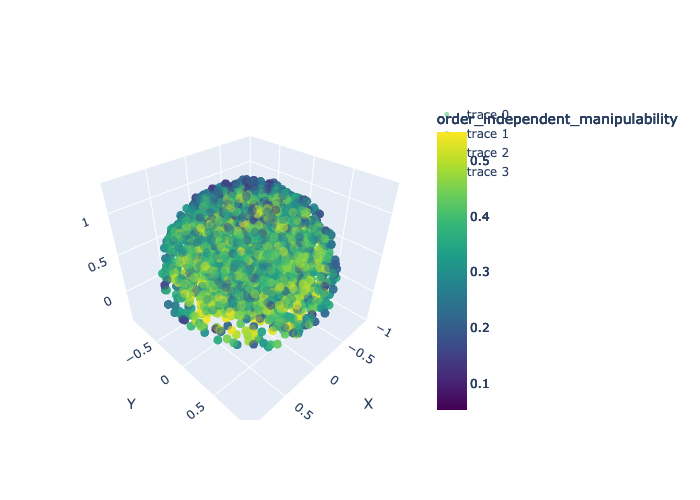

In [10]:
fig = ws.plot(color="order_independent_manipulability")
fig.show("png") # display the plot in PNG format for better visibility on github


In [11]:
ws.df

,x,y,z,order_independent_manipulability
0,-0.535547,0.617718,0.768830,0.392800
1,0.134561,0.083479,0.793458,0.456595
2,0.166145,-0.543364,-0.039319,0.482209
3,-0.407958,0.829137,0.430720,0.365465
4,0.404553,-0.221791,0.247064,0.346523
...,...,...,...,...
3295,0.026827,0.014759,0.587402,0.303092
3296,-0.279248,0.061119,0.403392,0.403340
3297,0.487865,0.410161,0.702331,0.450386
3298,0.057106,0.064081,0.113402,0.428913


## 3D voxel / volumetric plot

In [12]:
import matplotlib.pyplot as plt


Creating voxel representation...
Generating visualization...


/var/folders/x1/r8g1dmlj1dn7lz6z4bdx_mfr0000gn/T/ipykernel_85625/3101261540.py:87: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.

/var/folders/x1/r8g1dmlj1dn7lz6z4bdx_mfr0000gn/T/ipykernel_85625/3101261540.py:160: UserWarning:

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.




Workspace Statistics:
├─ Total data points: 3,300
├─ Voxel size: 0.100 m
├─ Grid dimensions: (19, 19, 17)
├─ Occupied voxels: 1,928
├─ Workspace volume: 1.9280 m³
└─ Fill ratio: 31.416%


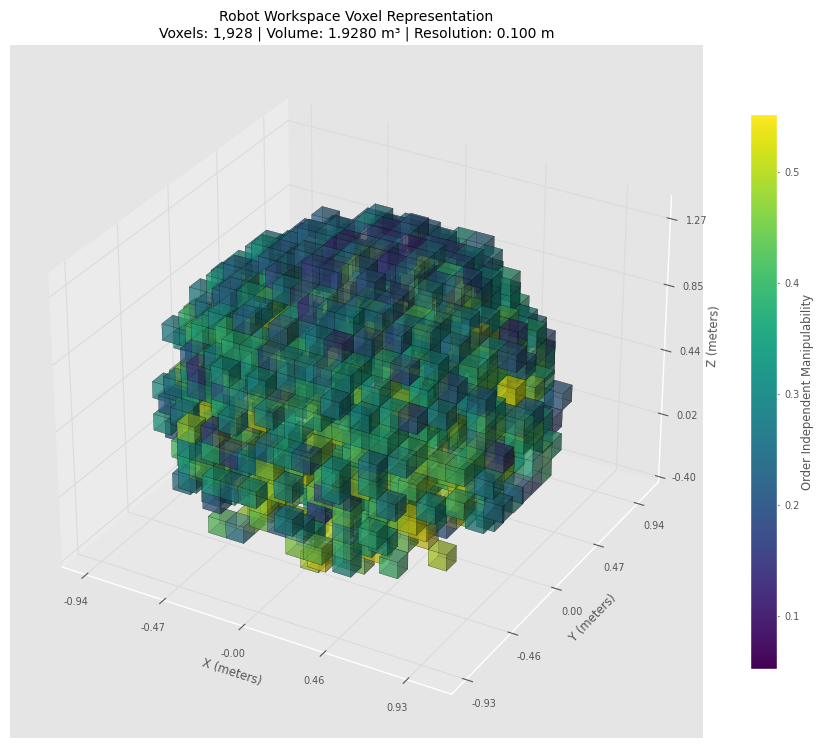

In [62]:
import numpy as np
from matplotlib.colors import Normalize

# Convert workspace data into voxel representation and visualize with manipulability coloring
import matplotlib.pyplot as plt

def create_voxel_workspace(df, voxel_size=0.05):
    """
    Convert workspace DataFrame to voxel representation.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Workspace data with columns ['x', 'y', 'z', 'order_independent_manipulability']
    voxel_size : float
        Size of each voxel in meters
    
    Returns:
    --------
    dict: Dictionary containing voxel data and metadata
    """
    # Get coordinate ranges
    coords = ['x', 'y', 'z']
    ranges = {coord: (df[coord].min(), df[coord].max()) for coord in coords}
    
    # Normalize and discretize coordinates to voxel indices
    indices = {}
    for coord in coords:
        min_val, max_val = ranges[coord]
        indices[f'{coord}_idx'] = ((df[coord] - min_val) / voxel_size).astype(int)
    
    # Create 3D grid
    grid_shape = tuple(indices[f'{coord}_idx'].max() + 1 for coord in coords)
    voxels = np.zeros(grid_shape, dtype=bool)
    manipulability_sum = np.zeros(grid_shape)
    count_values = np.zeros(grid_shape, dtype=int)
    
    # Populate voxel data
    for i in range(len(df)):
        x_idx = indices['x_idx'][i]
        y_idx = indices['y_idx'][i] 
        z_idx = indices['z_idx'][i]
        
        voxels[x_idx, y_idx, z_idx] = True
        manipulability_sum[x_idx, y_idx, z_idx] += df.iloc[i]['order_independent_manipulability']
        count_values[x_idx, y_idx, z_idx] += 1
    
    # Calculate average manipulability per voxel
    with np.errstate(divide='ignore', invalid='ignore'):
        avg_manipulability = np.divide(manipulability_sum, count_values,
                                     out=np.zeros_like(manipulability_sum),
                                     where=count_values > 0)
    
    return {
        'voxels': voxels,
        'avg_manipulability': avg_manipulability,
        'grid_shape': grid_shape,
        'ranges': ranges,
        'voxel_size': voxel_size,
        'total_voxels': np.sum(voxels),
        'total_volume': np.sum(voxels) * (voxel_size ** 3)
    }

def create_voxel_colors(voxels, avg_manipulability, manip_range, cmap_name='viridis', alpha=0.7):
    """
    Create color array for voxel visualization.
    
    Parameters:
    -----------
    voxels : numpy.ndarray
        Boolean array indicating voxel presence
    avg_manipulability : numpy.ndarray
        Average manipulability values per voxel
    manip_range : tuple
        (min, max) range for manipulability normalization
    cmap_name : str
        Matplotlib colormap name
    alpha : float
        Transparency value
    
    Returns:
    --------
    numpy.ndarray: RGBA color array
    """
    colors = np.zeros(voxels.shape + (4,))
    norm = Normalize(vmin=manip_range[0], vmax=manip_range[1])
    cmap = plt.cm.get_cmap(cmap_name)
    
    # Vectorized color assignment
    valid_voxels = np.where(voxels)
    if len(valid_voxels[0]) > 0:
        manip_values = avg_manipulability[valid_voxels]
        rgba_colors = cmap(norm(manip_values))
        rgba_colors[:, 3] = alpha  # Set alpha
        colors[valid_voxels] = rgba_colors
    
    return colors, norm, cmap

def plot_voxel_workspace(voxel_data, colors, norm, cmap, figsize=(12, 9)):
    """
    Create 3D voxel plot with proper coordinate scaling.
    
    Parameters:
    -----------
    voxel_data : dict
        Output from create_voxel_workspace()
    colors : numpy.ndarray
        RGBA color array
    norm : matplotlib.colors.Normalize
        Color normalization object
    cmap : matplotlib.colors.Colormap
        Colormap object
    figsize : tuple
        Figure size (width, height)
    
    Returns:
    --------
    matplotlib.figure.Figure: The created figure
    """
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot voxels
    ax.voxels(voxel_data['voxels'], facecolors=colors, edgecolors='k', alpha=0.5, linewidth=0.1)
    
    # Set coordinate labels and ticks
    ranges = voxel_data['ranges']
    grid_shape = voxel_data['grid_shape']
    
    # Create tick positions and labels
    for i, (coord, (min_val, max_val)) in enumerate(zip(['x', 'y', 'z'], 
                                                        [ranges['x'], ranges['y'], ranges['z']])):
        tick_positions = np.linspace(0, grid_shape[i] - 1, 5)
        tick_labels = np.linspace(min_val, max_val, 5)
        
        if coord == 'x':
            ax.set_xticks(tick_positions)
            ax.set_xticklabels([f'{val:.2f}' for val in tick_labels])
            ax.set_xlabel('X (meters)')
        elif coord == 'y':
            ax.set_yticks(tick_positions)
            ax.set_yticklabels([f'{val:.2f}' for val in tick_labels])
            ax.set_ylabel('Y (meters)')
        else:  # coord == 'z'
            ax.set_zticks(tick_positions)
            ax.set_zticklabels([f'{val:.2f}' for val in tick_labels])
            ax.set_zlabel('Z (meters)')
    
    # Add colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, label='Order Independent Manipulability', shrink=0.8)
    
    # Add title with statistics
    plt.title(f'Robot Workspace Voxel Representation\n'
             f'Voxels: {voxel_data["total_voxels"]:,} | '
             f'Volume: {voxel_data["total_volume"]:.4f} m³ | '
             f'Resolution: {voxel_data["voxel_size"]:.3f} m')
    
    plt.tight_layout()
    return fig

# Main execution
voxel_size = 0.1  # Voxel resolution in meters

# Create voxel representation
print("Creating voxel representation...")
voxel_data = create_voxel_workspace(df, voxel_size)

# Create colors based on manipulability
manip_range = (df['order_independent_manipulability'].min(), 
               df['order_independent_manipulability'].max())
colors, norm, cmap = create_voxel_colors(voxel_data['voxels'], 
                                       voxel_data['avg_manipulability'],
                                       manip_range)

# Create visualization
print("Generating visualization...")
fig_voxel = plot_voxel_workspace(voxel_data, colors, norm, cmap)

# Display statistics
print(f"\nWorkspace Statistics:")
print(f"├─ Total data points: {len(df):,}")
print(f"├─ Voxel size: {voxel_size:.3f} m")
print(f"├─ Grid dimensions: {voxel_data['grid_shape']}")
print(f"├─ Occupied voxels: {voxel_data['total_voxels']:,}")
print(f"├─ Workspace volume: {voxel_data['total_volume']:.4f} m³")
print(f"└─ Fill ratio: {voxel_data['total_voxels'] / np.prod(voxel_data['grid_shape']):.3%}")

plt.show()


In [78]:
# Holds voxel data with one segmentation class value >0 and bg class = 0
import numpy as np

class Coordinate():

    def __init__(self, xyz):
        self.x = xyz[0]
        self.y = xyz[1]
        self.z = xyz[2]


class VoxelData():

    
    def __init__(self,data):
        print("Making voxels")
        self.data = data
        self.triangles = np.zeros((np.size(np.shape(self.data)),1)) 
        self.xyz = self.get_coords()
        # self.x = self.xyz[0,:]
        # self.y = self.xyz[1,:]
        # self.z = self.xyz[2,:]
        self.x_length = np.size(data,0)
        self.y_length = np.size(data,1)
        self.z_length = np.size(data,2)
        self.vert_count = 0
        self.vertices = self.make_edge_verts()
        # self.vertices = self.make_cube_verts()
        self.triangles = np.delete(self.triangles, 0,1)
        #self.make_triangles()


    def get_coords(self):
        indices = np.nonzero(self.data)
        indices = np.stack((indices[0], indices[1],indices[2]))
        return indices

    def has_voxel(self,neighbor_coord):
        return self.data[neighbor_coord[0],neighbor_coord[1],neighbor_coord[2]]


    def get_neighbor(self, voxel_coords, direction):
        x = voxel_coords[0]
        y = voxel_coords[1]
        z = voxel_coords[2]
        offset_to_check = CubeData.offsets[direction]
        neighbor_coord = [x+ offset_to_check[0], y+offset_to_check[1], z+offset_to_check[2]]

        # return 0 if neighbor out of bounds or nonexistent
        if (any(np.less(neighbor_coord,0)) | (neighbor_coord[0] >= self.x_length) | (neighbor_coord[1] >= self.y_length) | (neighbor_coord[2] >= self.z_length)):
            return 0
        else:
            return self.has_voxel(neighbor_coord)


    def remove_redundant_coords(self, cube):
        i = 0
        while(i < np.size(cube,1)):
            coord = (cube.T)[i]
            cu = cube[:, cube[0,:] == coord[0]]
            cu = cu[:, cu[1,:] == coord[1]]
            cu = cu[:, cu[2,:] == coord[2]]
            # if more than one coord of same value, delete
            if i >= np.size(cube,1):
                break
            if np.size(cu, 1) >1:
                cube = np.delete(cube, i, 1) 
                i = i-1
            i+=1    
        return cube

    
    def make_face(self, voxel, direction):
        voxel_coords = self.xyz[:, voxel]
        explicit_dir = CubeData.direction[direction]
        vert_order = CubeData.face_triangles[explicit_dir]

        # Use if triangle order gets fixed
        # next_triangles = np.add(vert_order, voxel)
        # next_i = [next_triangles[0], next_triangles[0]]
        # next_j = [next_triangles[1], next_triangles[2]]
        # next_k = [next_triangles[2], next_triangles[3]]
        
        next_i = [self.vert_count, self.vert_count]
        next_j = [self.vert_count+1, self.vert_count+2]
        next_k = [self.vert_count+2, self.vert_count+3]

        next_tri = np.vstack((next_i, next_j, next_k))
        self.triangles = np.hstack((self.triangles, next_tri))
        # self.triangles = np.vstack((self.triangles, next_triangles))

        face_verts = np.zeros((len(voxel_coords),len(vert_order)))
        for i in range(len(vert_order)):
            face_verts[:,i] = voxel_coords + CubeData.cube_verts[vert_order[i]]   

        self.vert_count = self.vert_count+4       
        return face_verts


    def make_cube_verts(self, voxel):
        voxel_coords = self.xyz[:, voxel]
        cube = np.zeros((len(voxel_coords), 1))

        # only make a new face if there's no neighbor in that direction
        dirs_no_neighbor = []
        for direction in range(len(CubeData.direction)):
            if np.any(self.get_neighbor(voxel_coords, direction)):
                continue
            else: 
                dirs_no_neighbor = np.append(dirs_no_neighbor, direction)
                face = self.make_face(voxel, direction)
                cube = np.append(cube,face, axis=1)

        # remove cube initialization
        cube = np.delete(cube, 0, 1) 

        # remove redundant entries: not doing this cuz it messes up the triangle order
        # and i'm too lazy to fix that so excess vertices it is
        # cube = self.remove_redundant_coords(cube)
        return cube


    def make_edge_verts(self):
        # make only outer vertices 
        edge_verts = np.zeros((np.size(self.xyz, 0),1))
        num_voxels = np.size(self.xyz, 1)
        for voxel in range(num_voxels):
            cube = self.make_cube_verts(voxel)          # passing voxel num rather than 
            edge_verts = np.append(edge_verts, cube, axis=1)
        edge_verts = np.delete(edge_verts, 0,1)
        return edge_verts        




    
class CubeData:
    # all data and knowledge from https://github.com/boardtobits/procedural-mesh-tutorial/blob/master/CubeMeshData.cs
    # for creating faces correctly by direction
    face_triangles = {
		'North':  [0, 1, 2, 3 ],        # +y
        'East': [ 5, 0, 3, 6 ],         # +x
	    'South': [ 4, 5, 6, 7 ],        # -y
        'West': [ 1, 4, 7, 2 ],         # -x
        'Up': [ 5, 4, 1, 0 ],           # +z
        'Down': [ 3, 2, 7, 6 ]          # -z
	}

    cube_verts = [
        [1,1,1],
        [0,1,1], 
        [0,1,0],
        [1,1,0],
        [0,0,1],
        [1,0,1],
        [1,0,0],
        [0,0,0],
    ]

    # cool twist
    # cube_verts = [
    #     [0,0,0],
    #     [1,0,0],
    #     [1,0,1], 
    #     [0,0,1],
    #     [0,1,1], 
    #     [1,1,1],
    #     [1,1,0],
    #     [0,1,0],
    # ]

    # og
    # cube_verts = [
    #     [1,1,1],
    #     [0,1,1], 
    #     [0,0,1],
    #     [1,0,1], 
    #     [0,1,0],
    #     [1,1,0],
    #     [1,0,0],
    #     [0,0,0]
    # ]

    direction = [
        'North',
        'East',
        'South',
        'West',
        'Up',
        'Down'
    ]

    opposing_directions = [
        ['North','South'],
        ['East','West'], 
        ['Up', 'Down']
    ]

    # xyz direction corresponding to 'Direction'
    offsets = [  
        [0, 1, 0], 
        [1, 0, 0],   
        [0, -1, 0],
        [-1, 0, 0],
        [0, 0, 1],
        [0, 0, -1],
    ]
    # offsets = [             
    #     [0, 0, 1],
    #     [1, 0, 0],
    #     [0, 0, -1],
    #     [-1, 0, 0],
    #     [0, 1, 0],
    #     [0, -1, 0]
    # ]



In [66]:
# print(voxel_data["avg_manipulability"])
# print the avg_manipulability bigger than 0.1
# print("Average manipulability values greater than 0.1:")
print(voxel_data['avg_manipulability'][voxel_data['avg_manipulability'] > 0.1])

[0.33073929 0.31270831 0.19227229 ... 0.43439419 0.3522946  0.36697305]


In [75]:
print(voxel_data['voxels'].shape)
print(voxel_data['voxels'].flatten().shape)
print(voxel_data['avg_manipulability'].flatten().shape)
print(Voxels.triangles[0].shape)
print(Voxels.vertices[0].shape)

(19, 19, 17)
(6137,)
(6137,)
(8812,)
(17624,)


In [79]:
import plotly.graph_objects as go

Voxels = VoxelData(voxel_data['voxels'])
# Colors =
# print("Voxels.data\n",Voxels.data)
# print("Voxels.vertices\n",Voxels.vertices)
# print("Voxels.triangles\n",Voxels.triangles)

print("Generating figure")
fig = go.Figure(data=go.Mesh3d(
    x=Voxels.vertices[0],
    y=Voxels.vertices[1],
    z=Voxels.vertices[2],
    i=Voxels.triangles[0],
    j=Voxels.triangles[1],
    k=Voxels.triangles[2],
    intensity=voxel_data['avg_manipulability'],
    intensitymode='cell',
    color='lightblue'  # Single color
))
fig.show()

Making voxels
Generating figure
